# Lab 3: Two Axis Control and Dynamical Decoupling with CPMG

**Setup B**

Press Shift+Enter to run each code segment. The raw data generated by this notebook can be found in the folder './data/{todays_date}/'.

##### Load Libraries

In [ ]:
%matplotlib widget

import qcodes as qc
import qcodes.utils.validators as vals
from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.loops import Loop
from qcodes.data.data_set import load_data
from qcodes.actions import Task, Wait
from qcodes.measure import Measure
from qcodes.utils import magic

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research.SR830 as stanford_research

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

##### Connect to Instruments

In [ ]:
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(300)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='GPIB0::13::INSTR')
microwave_src = anritsu.MG3681A('microwave_src', 'GPIB0::3::INSTR')
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')
microwave_src.pulse_modulation('OFF')
dc_supply = korad.KD3305P('dc_supply', 'ASRL4::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

station=qc.Station(pulse_blaster, lock_in_amp, microwave_src)
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider = loc_provider

## Task 3.0: Preliminary Experiments
### Task 3.0.0: ODMR - Finding the resonance frequency

The aim of this lab is to study various pulse sequences related to probing the spin dynamics of the NV centre and extending its coherence time. But before we can do that we must find the resonance frequency of our system. We will do this by measuring an ODMR spectrum.

For this lab we will use a magnetic field of ~ 4 mT. Set the magnetic field with the code below.

In [ ]:
dc_supply.ch1.current_setpoint(0.235)
dc_supply.ch1.voltage_setpoint(12)

We will now program the PulseBlaster to output the pulse sequence for ODMR. Complete the code below, you should be familiar with this from the previous labs.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

#TODO: Fill out the values below.
laser_f = 100e3                              #Laser modulation frequency.
laser_D = 0.5                                #Laser modulation duty cycle.
T_laser_on =                                 #Laser time on. 
T_laser_off =                                #Laser time off.
N_laser_pulses =                             #Number of laser pulses that can fit in the reference period.

mw_f = laser_f                               #Microwave modulation frequency.
mw_D = laser_D                               #Microwave modulation duty cycle.
T_mw_on =                                    #Microwave time on.
T_mw_off =                                   #Microwave time off.
N_mw_pulses =                                #Number of microwave pulses that can fit in the reference period.

#TODO: Fill out the pulse sequences below.
pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock-in reference pulse sequence.
)                                            
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence.
)                                           
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the microwave modulation pulse sequence.
)                                     
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Run the ODMR spectrum measurement. Choose a microwave power for required to resolve all transitions resulant from the hyperfine transitions.

In [ ]:
#TODO: Enter the values below
microwave_src.power(#Enter the microwave power here!)

microwave_src.output('ON')
lock_in_amp.time_constant(100e-3)
lock_in_amp.sensitivity(50e-6)

loop = Loop(microwave_src.frequency.sweep(2.965e9, 2.987e9, num=150),
            delay=5*lock_in_amp.time_constant()).each(lock_in_amp.R)
#Plot the measurement
data_ODMR = loop.get_data_set(name='ODMR')
plot = MatPlot(data_ODMR.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

Select the transition with the lowest frequency and set the microwave source to that frequency below.

In [ ]:
microwave_src.frequency(#Enter the frequency here!.)

### Task 3.0.1 Rabi

Just as we need to find the transition frequency we also need to the find time ($T_{X_{\pi}}$) required to rotate the spins from $|0\rangle$ to $|+1\rangle$ about the x-axis of the bloch sphere. To do so we will measure the frequency of some Rabi oscillations. 

First set the microwave source power.

In [ ]:
microwave_src.power(15)

Now write the pulse sequence to generate Rabi oscillations.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

laser_f = 100e3                              #Laser modulation frequency.
laser_D = 0.5                                #Laser modulation duty cycle.
T_laser_on =                                 #Laser time on. 
T_laser_off =                                #Laser time off.
N_laser_pulses =                             #Number of laser pulses that can fit in the reference period.

mw_f = laser_f                               #Microwave modulation frequency.
T_mw_on = qc.ManualParameter('T_mw_on', label='tau', initial_value=20e-9, unit='s')
def get_T_mw_off():
    return T_laser_on + T_laser_off - T_mw_on()
T_mw_off = qc.Parameter('T_mw_off', get_cmd=get_T_mw_off, unit='s')
N_mw_pulses = int(ref_D * N_laser_pulses)    #Number of microwave pulses that can fit in the reference period.


#TODO: Fill out the pulse sequences below.
pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock-in reference pulse sequence.
)                                            
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence.
)                                           
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the microwave modulation pulse sequence.
)                                     
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Run the experiment.

In [ ]:
lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(200e-6)

microwave_src.output('ON')

loop = Loop(T_mw_on.sweep(40e-9, 1e-6, step=40e-9)).each(
    Task(pulse_blaster.flush_channel_buffer),
    Wait(5 * lock_in_amp.time_constant()),
    lock_in_amp.R
)
#Plot the measurement
data_Rabi = loop.get_data_set(name='Rabi')
plot = MatPlot(data_Rabi.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

Enter $T_{X_{\pi}}$ - the time required to rotate the spins from $|0\rangle$ to $|+1\rangle$ about the x-axis - where specified below. Enter it to the nearest 20 ns. For this task you can just eyeball it. If you feel like expending a little more effort you can run the fitting code from the previous lab and extract $T_{X_{\pi}}$ from the fitted Rabi frequency.

In [ ]:
T_X_pi = #Enter the PI rotation time here.
T_X_pi_2 = T_X_pi / 2

## Task 3.3 Ramsey Fringes

Now that we have measured these experimental parameters we can now begin the lab in proper. The first task is to measure the dephasing time $T_2^*$, which is done so by measuring the decay time of Ramsey fringes.

We can measure Ramsey fringes by applying the following gates:

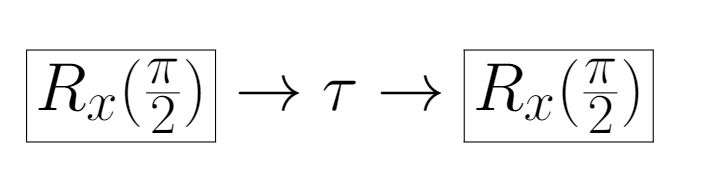

or in other words, the pulse sequence:

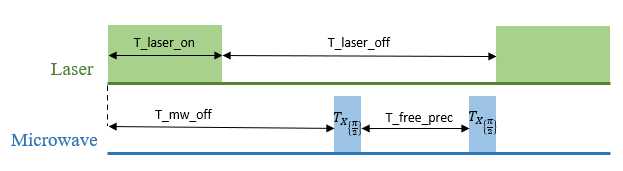

The values such as laser and reference on/off times as well as the free precession time ($\tau$; T_free_prec in the code below) has been given. Program the PulseBlaster to perfrom a Ramsey fringes experiment below.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

laser_f = 100e3                              #Laser modulation frequency.
laser_D = 0.5                                #Laser modulation duty cycle.
T_laser_on = laser_D * 1 / laser_f           #Laser time on. 
T_laser_off = (1 - laser_D) * 1 / laser_f    #Laser time off.
N_laser_pulses = round(laser_f / ref_f)      #Number of laser pulses that can fit in the reference period.

ramsey_f = laser_f                           #Ramsey repition rate
N_ramsey = int(ref_D * N_laser_pulses)       #Number of Ramsey measurements within one period of the reference frequency
T_free_prec = qc.ManualParameter(            #The free precession time i.e. tau - the time between the two X_pi gates.
    'T_free_prec', label='tau', initial_value=40e-9, unit='s')
def get_T_mw_off():
    return T_laser_on + T_laser_off - 2 * T_X_pi_2 - T_free_prec()
T_mw_off = qc.Parameter('T_mw_off', get_cmd=get_T_mw_off, unit='s')

#TODO: Fill out the pulse sequences below.
pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock-in reference pulse sequence.
)                                            
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence.
)                                           
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the 'I' microwave modulation pulse sequence.
)                                     
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Run the measurement.

In [ ]:
lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(200e-6)

microwave_src.output('ON')

loop = Loop(T_free_prec.sweep(20e-9, 2e-6, step=20e-9)).each(
    Task(pulse_blaster.flush_channel_buffer),
    Wait(5 * lock_in_amp.time_constant()),
    lock_in_amp.R
)
#Plot the measurement
data_Ramsey_XX = loop.get_data_set(name='Ramsey_XX')
plot = MatPlot(data_Ramsey_XX.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

#### Q1. Comment on the feature of your Ramsey experiment. In particular, comment on the direction of the decay, and the frequency of the oscillations.

A parameter of interest is the $T_2^*$, which can be extrated by fitting the measured data to the appropriate theoretical model. In previous labs, we have demonstrated how to fit a curve using python. In your own time, using python or another software package (e.g. MatLab, OriginPro, etc.) fit the data to the appropriate model and extract the $T_2^*$ time. 

**You must show the fitted curve, the fit model and $T_2^*$ in your lab report.**

## Task 3.2: Two-Axis Control

Thus far, we have been performing operations with microwave driving pulses that are always kept in phase with the spins. Let’s suppose that all our pulses have been $R_x(\theta)$ operations.Changing the phase of the microwave pulses by 90◦ will result in rotations about the y-axis; $R_y(\theta)$. We will still use the same microwave source as before, but now introduce another input, given by Channel 3 of the pulse blaster. Together with the input from Channel 2, we will be performing IQ-modulation of the microwave carrier wave.

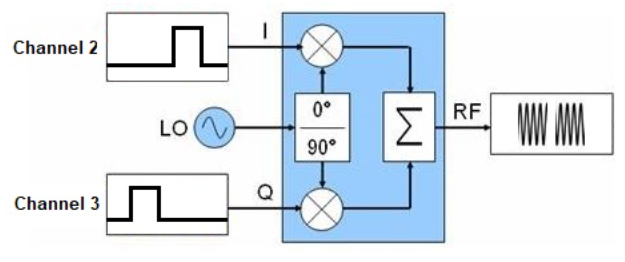

The local oscillator (’LO’) is a continuously running oscillator; its phase never changes. We have two independent signals (labelled Channel 2 and Channel 3 in Figure 1) that are the ’I’ and ’Q’ inputs to the IQ modulator. The ’I’ input amplitude-modulates the local oscillator. The ’Q’ input amplitude-modulates a copy of the ’LO’ with a 90-degree phase difference. These two amplitude modulated signals are inputs to a hardware summing junction, and the final sum is delivered to the antenna.

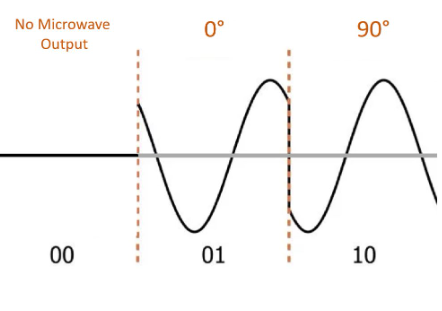

The power output from the I and Q channels may not be the same, and therefore the time taken to rotate the spins from $|0\rangle$ to $|-1\rangle$ using the Q channel ($T_{Y_\pi}$) may not be the same. Modify the code in Task 3.0.1 to measure Rabi oscillations using the Q channel i.e. Channel 3 of the PulseBlaster and then enter $T_{Y_\pi}$ (to the nearest 100 ns) below.

In [ ]:
T_Y_pi = #Enter the PI rotation time here.
T_Y_pi_2 = T_Y_pi / 2

Now, we will repeat the Ramsey experimen with an 'XY' pulse sequence. That is the first microwave pulse produces a $R_x(\pi/2)$ gate and the second microwave pulse produces a $R_y(\pi/2)$ gate. Construct the pulse sequence below.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

laser_f = 100e3                              #Laser modulation frequency.
laser_D = 0.5                                #Laser modulation duty cycle.
T_laser_on = laser_D * 1 / laser_f           #Laser time on. 
T_laser_off = (1 - laser_D) * 1 / laser_f    #Laser time off.
N_laser_pulses = round(laser_f / ref_f)      #Number of laser pulses that can fit in the reference period.

ramsey_f = laser_f                           #Ramsey repition rate
N_ramsey = int(ref_D * N_laser_pulses)       #Number of Ramsey measurements within one period of the reference frequency
T_free_prec = qc.ManualParameter(            #The free precession time i.e. the time between the two X_pi gates.
    'T_free_prec', label='tau', initial_value=40e-9, unit='s')
def get_T_mw_off():
    return T_laser_on + T_laser_off - T_X_pi_2 - T_Y_pi_2 - T_free_prec()
T_mw_off = qc.Parameter('T_mw_off', get_cmd=get_T_mw_off, unit='s')

#TODO: Fill out the pulse sequences below.
pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock-in reference pulse sequence.
)                                            
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence.
)                                           
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the 'I' microwave modulation pulse sequence.
) 
pulse_blaster.ch3.pulse_sequence_buffer.set(
    #TODO: Enter the 'Q' microwave modulation pulse sequence.
) 
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Run the experiment below.

In [ ]:
lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(200e-6)

microwave_src.output('ON')

loop = Loop(T_free_prec.sweep(40e-9, 2e-6, step=40e-9)).each(
    Task(pulse_blaster.flush_channel_buffer),
    Wait(5 * lock_in_amp.time_constant()),
    lock_in_amp.R
)
#Plot the measurement
data_Ramsey_XY = loop.get_data_set(name='Ramsey_XY')
plot = MatPlot(data_Ramsey_XY.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

In your own time, fit the data to the appropriate model and extract $T_2^*$. You must show both the fit and $T_2^*$ in your lab report.

## Task 3.3: The Hahn Echo

Ia a Hahn echo pulse sequence, we introduce an additional pulse. The sequence looks as follows:

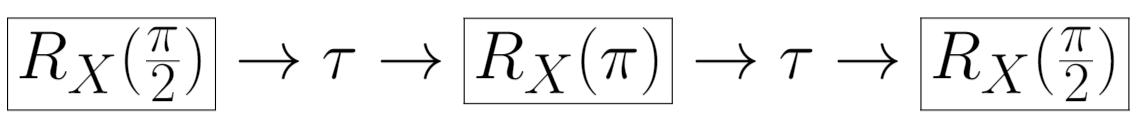

Construct the pulse sequence below using the pre-define timing parameters. The pulse sequence should look similar to:

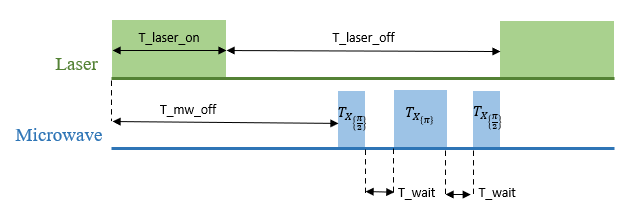

where T_free_prec is 3 $\times$ T_wait.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

laser_f = 25e3                               #Laser modulation frequency.
laser_D = 0.25                               #Laser modulation duty cycle.
T_laser_on = laser_D * 1 / laser_f           #Laser time on. 
T_laser_off = (1 - laser_D) * 1 / laser_f    #Laser time off.
N_laser_pulses = round(laser_f / ref_f)      #Number of laser pulses that can fit in the reference period.

ramsey_f = laser_f                           #Hahn echo repitition rate.
N_hahn = int(ref_D * N_laser_pulses)         #Number of Hahn echo repitions per reference freuquency period.
T_free_prec = qc.ManualParameter(            #The total free precision time 
    'T_free_prec', label='tau', initial_value=200e-9, unit='s')
def get_T_mw_off():
    return T_laser_on + T_laser_off - 4 * T_X_pi_2 - T_free_prec()
T_mw_off = qc.Parameter(                     #Time for which the microwave is off
    'T_mw_off', get_cmd=get_T_mw_off, unit='s')
def get_T_wait():
    return int((T_free_prec() / 2) * 1e-8) * 1e8
T_wait = qc.Parameter(                       #The time between rotations.
    'T_wait', get_cmd=get_T_wait, unit='s')

#TODO: Fill out the pulse sequences below.
pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock-in reference pulse sequence.
)                                            
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence.
)                                           
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the 'I' microwave modulation pulse sequence.
)                                     
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Run the experiment.

In [ ]:
lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(50e-6)

microwave_src.output('ON')

loop = Loop(T_free_prec.sweep(400e-9, 8e-6, step=400e-9)).each(
    Task(pulse_blaster.flush_channel_buffer),
    Wait(5 * lock_in_amp.time_constant()),
    lock_in_amp.R
)
#Plot the measurement
data_Hahn = loop.get_data_set(name='Hahn')
plot = MatPlot(data_Hahn.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

In your own time, fit the data to the appropriate model and extract $T_2^H$. You must show both the fit and $T_2^H$ in your lab report.

#### Q2. Record your $T_2^H$ time. Do you expect this to be longer or shorter than $T_2^*$? Secondly, explain why you expect the signal to decay in the direction that it does.

## Task 3.4: CPMG

A CPMG pulse sequence adds to the Hahn echo in Task 3 by performing the refocusing pulsein a way that makes it robust to pulse errors. A 1-pulse CPMG pulse sequence looks as follows:

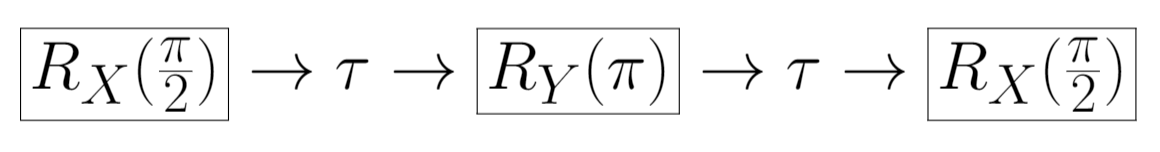

The pulse sequence can be extended by adding $R_y(\pi)$ pulses between the two $R_x(\pi/2)$ pulses. For example, a two pulse CPMG sequence is  $R_x(\pi/2) \rightarrow R_y(\pi) \rightarrow R_y(\pi) \rightarrow R_x(\pi/2)$.

Define the number of pulses below.

In [ ]:
N_CPMG_pulses = 1

Now construct the CPMG pulse sequence below, the timing parameters have been already been defined for you. 

For example, the 2-pulse CPMG - using the below timing parameters -  should look like:

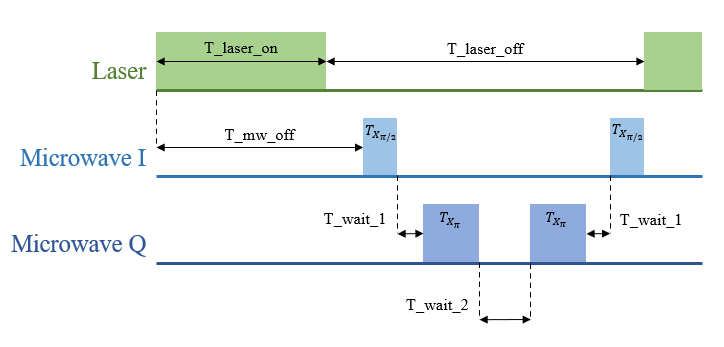

where the free precession time $\tau$ is 2 $\times$ T_wait_2 + 2 $\times$ T_wait_1 and T_wait_2 is double T_wait_1. 

For the 4-pulse CPMG set the laser modulation frequency (laser_f) to 20 kHz. Set the duty cycle (laser_D) to 0.2.

In [ ]:
ref_f = 200                                  #Reference frequency.
ref_D = 0.5                                  #Reference duty cycle.
T_ref_on = ref_D * 1 / ref_f                 #Reference time on.
T_ref_off = (1 - ref_D) * 1 / ref_f          #Reference time off.

laser_f = 25e3                               #Laser modulation frequency.
laser_D = 0.25                               #Laser modulation duty cycle.
T_laser_on = laser_D * 1 / laser_f           #Laser time on. 
T_laser_off = (1 - laser_D) * 1 / laser_f    #Laser time off.
N_laser_pulses = round(laser_f / ref_f)      #Number of laser pulses that can fit in the reference period.

CPMG_f = laser_f                             #CPMG repitition rate.
N_CPMG = int(ref_D * N_laser_pulses)         #Number of CPMG pulses per reference frequency period.
T_free_prec = qc.ManualParameter(            #The total free precession time.
    'T_free_prec', label='tau', initial_value=320e-9, unit='s')
def get_T_mw_off():
    return T_laser_on + T_laser_off -  \
           N_CPMG_pulses * T_Y_pi - T_X_pi - \
           T_free_prec()
T_mw_off = qc.Parameter(                     #Microwave off time.
    'T_mw_off', get_cmd=get_T_mw_off, unit='s')
def get_T_wait_1():
    return 0.5 * T_free_prec() / (N_CPMG_pulses)
T_wait_1 = qc.Parameter(                     #Time between rotations.
    'T_wait_1', get_cmd=get_T_wait_1, unit='s')
def get_T_wait_2():
    return (T_free_prec() / N_CPMG_pulses)
T_wait_2 = qc.Parameter(                     #Time between rotations.
    'T_wait_2', get_cmd=get_T_wait_2, unit='s')

#TODO: Fill out the pulse sequences below.
pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
pulse_blaster.ch0.pulse_sequence_buffer.set(
    #TODO: Enter the lock-in reference pulse sequence.
)                                            
pulse_blaster.ch1.pulse_sequence_buffer.set(
    #TODO: Enter the laser pulse sequence.
)                                           
pulse_blaster.ch2.pulse_sequence_buffer.set(
    #TODO: Enter the 'I' microwave modulation pulse sequence.
) 
pulse_blaster.ch3.pulse_sequence_buffer.set(
    #TODO: Enter the 'Q' microwave modulation pulse sequence.
) 
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Before performing the 4-pulse CPMG change the 'T_free_prec.sweep(start=320e-9, stop=20.16e-6, step=320e-9)' to 'T_free_prec.sweep(start=640e-9, stop=30.08e-6, step=640e-9)' in the loop function in the code segment below. Also change the lock-in amplifier sensitivity to 50e-6.

In [ ]:
lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(100e-6)

microwave_src.output('ON')

loop = Loop(T_free_prec.sweep(start=320e-9, stop=20.16e-6, step=320e-9)).each(
    Task(pulse_blaster.flush_channel_buffer),
    Wait(5 * lock_in_amp.time_constant()),
    lock_in_amp.R
)
#Plot the measurement
data_CPMG = loop.get_data_set(name='CPMG_{:d}_pulses'.format(N_CPMG_pulses))
plot = MatPlot(data_CPMG.lock_in_amp_R)
plot.tight_layout()
loop.with_bg_task(plot.update)

In [ ]:
#Run the measurement
loop.run()
plot.update()

Repeat the task with 2 and 4 pulses. If you have time attemp an 8-pulse CPMG. Record and compare your $T_2^{CPMG}$. In your own time, fit the data to the appropriate model and extract $T_2^{CPMG}$. You must show both the fit and $T_2^{CPMG}$ in your lab report. 

#### Q3. For a particular τ, how do the center frequencies of the bandpass filter functions created by the 3 different CPMG pulse sequences compare? Based on this understanding, what type of noise is most likely associated with the dephasing of the spins? Finally, as before, explain why a CPMG pulse sequence decays in the direction that you observe in your experiment?

##### Turn off the instruments

In [ ]:
pulse_blaster.stop()
microwave_src.output('OFF')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

## Appendix A: Installing QCoDeS

This lab uses the open-source qcodes library to manage experimental data. To work on this lab at home, you will need to install Python >3.7 and qcodes. 

Qcodes can be installed by running the command:

or in anaconda:

For futher information, visit: https://qcodes.github.io/Qcodes/start/index.html

## Appendix B: Accessing Your Data

You may run a measurement many times - let's say 5 times - and decide that the third run is the measurement you would like to plot for your lab report. Or you would like to access the data to perform some analysis. Unfortunately, the notebook is showing the latest run, run 5. Thus, you must be able to import your data into the notebook. Thankfully qcodes provides a method to load saved data. To use it first it must be imported as follows.

In [ ]:
from qcodes.data.data_set import load_data

This can be done by calling the function 'load_data' the data location as the argument. The data location for each experiment, is saved in a directory formatted as ./data/YYYY-MM-DD/#{Three-digit experiment id}_{Experiement name}_hh_mm_ss'. This location is also figure title for any experiments run. For example:

In [ ]:
test_data1 = load_data('test1')
test_data2 = load_data('test2')

You can then plot the data by calling the function 'MatPlot' as shown below. When using 'Matplot', multiple dataset may be plotted. If supplied in the argument list as Matplot(dataset1, dataset2, ...), 'MatPlot' will create subplots with each dataset plotted within its own subplot. If the datasets are supplied as Matplot([dataset1, dataset2, ...]), the datasets will be plotted on the same axis.

In [ ]:
MatPlot(test_data1.y, test_data2.y)

Convert the data into a numpy array for data processing or curve fitting can be done so by calling the 'reval' method of the parameter you would like to convert in the data set. Remember to add the '_set' suffix if the paramter was swept. 

In [ ]:
test_data1.x_set.ravel()
test_data1.y.ravel()